In [1]:
from typing import Callable, Tuple
from finite_distributions.FiniteDistribution import FiniteDistribution
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sinkhorn.SinkhornRunner as SinkhornRunner
import sinkhorn.SinkhornKernels as skern
import visualizer.joint_distribution_visualizer as jdv
import pandas as pd

from core.require import require

from PIL import Image, ImageDraw

In [5]:
# Load the image (convert to grayscale or keep RGB depending on your need)
# img_1 = Image.open("images/white_circle_on_black.png").convert("L")  # Use "RGB" if you want color
# img_2 = Image.open("images/white_square_on_black.png").convert("L")  # Use "RGB" if you want color
img_1 = Image.open("images/black_square_on_white.png").convert("L")  # Use "RGB" if you want color
img_2 = Image.open("images/black_circle_on_white.png").convert("L")  # Use "RGB" if you want color
# img_1 = Image.open("images/white_square_on_black.png").convert("L")  # Use "RGB" if you want color
# img_2 = Image.open("images/white_circle_on_black.png").convert("L")  # Use "RGB" if you want color



# Convert to NumPy array
img_1_array = np.array(img_1)/255
img_2_array = np.array(img_2)/255

require(img_1_array.shape == img_2_array.shape)
require(len(img_1_array.shape) == 2)

rows = img_1_array.shape[0]
cols = img_1_array.shape[1]
require(rows == cols)

keys = [(x, y) for x in range(rows) for y in range(cols)]

np.array([[1, 2]]).shape

# create distributions
__sum_1 = img_1_array.sum()
# img_1_distribution = FiniteDistribution({rows * x + y: img_1_array[x][y]/__sum_1 for (x, y) in keys})
img_1_distribution = FiniteDistribution({(x, y): img_1_array[x][y]/__sum_1 for (x, y) in keys})
img_1_distribution_reduced = FiniteDistribution({x: v for (x, v) in img_1_distribution.elementMapping.items() if v > 0})

__sum_2 = img_2_array.sum()
# img_2_distribution = FiniteDistribution({rows * x + y: img_2_array[x][y]/__sum_2 for (x, y) in keys})
img_2_distribution = FiniteDistribution({(x, y): img_2_array[x][y]/__sum_2 for (x, y) in keys})
img_2_distribution_reduced = FiniteDistribution({x: v for (x, v) in img_2_distribution.elementMapping.items() if v > 0})


In [ ]:
c = lambda x, y: 0.5*((x[0] - y[0])**2 + (x[1] - y[1])**2)

In [8]:
# p-norm
# p = 2.
# sinkhorn_runner = skern.get_quadratically_regularized_runner(c, use_parallelization=True)
# entropic
sinkhorn_runner_entropic = skern.get_entropically_regularized_runner(c)

epsilons = [0.5]#, 0.5, 1.0, 5.0, 10.0, 100.0]
delta = 0.025 # lower delta for entropic


for epsilon in reversed(epsilons):
    # print("Running quadratic.")
    # pi, f, g, inner_p, outer_p = sinkhorn_runner.run_sinkhorn(img_1_distribution, img_2_distribution, epsilon, delta, dual_potential_precision_mult = 0.5, printInfo= True)
    # print(f"Ran quadratic. Took {outer_p} outer iterations.")

    print(f"Running entropic for epsilon = {epsilon}.")
    pi, f, g, inner_e, outer_e = sinkhorn_runner_entropic.run_sinkhorn(img_1_distribution_reduced, img_2_distribution_reduced, epsilon, delta, printInfo=True)
    print(f"Ran entropic. Took {outer_e} outer iterations.")

    # interpolate two images geodesically
    pi_element_mapping = pi.elementMapping
    for interp in np.linspace(0.0, 1.0, 10):
        interp = round(interp, 2)
        all_interpolations = [{"x": int(interp * x0 + (1 - interp) * x1), "y": int(interp * y0 + (1 - interp) * y1), "p": p} for ((x0, y0), (x1, y1)), p in pi_element_mapping.items()]
        all_interpolations = all_interpolations + [{"x": int(x), "y": int(y), "p": 0.0} for (x, y) in img_1_distribution.get_keys()]
        pi_pandas = pd.DataFrame(all_interpolations)
        aggregated = pi_pandas.groupby(["x", "y"]).sum()
        max_weight = aggregated["p"].max()
        aggregated["p"] = 255 * aggregated["p"] / max_weight
        # add in elements
        composite_img_array = aggregated.unstack().values

        composite_img = Image.fromarray(composite_img_array.astype(np.uint8))
        # composite_img.show()
        # composite_img.save(f"images/TEST_black_composite_img_p_entropic_epsilon_{round(epsilon, 3)}.png")
        # composite_img.save(f"images/black_composite_img_p_epsilon_{round(epsilon, 4)}.png")
        # composite_img.save(f"images/white_composite_img_p_entropic_epsilon_{round(epsilon, 3)}.png")
        # composite_img.save(f"images/interp/white_composite_img_p_entropic_epsilon_{round(epsilon, 3)}_interp_{round(interp, 3)}.png")
        # composite_img.save(f"images/interp/black_composite_img_p_quadratic_epsilon_{round(epsilon, 3)}_interp_{round(interp, 3)}.png")
        composite_img.save(f"images/interp/black_composite_img_p_entropic_epsilon_{round(epsilon, 3)}_interp_{round(interp, 3)}.png")

Running entropic for epsilon = 0.5.
Prior outer iterations: 1. inner iterations: 0.
Iterations for g: 15098880
Iterations for f: 15098880
Error: 0.1303102500331002
outer iterations: 1. inner iterations: 30197760. Error: 0.1303102500331002
Prior outer iterations: 2. inner iterations: 30197760.
Iterations for g: 15098880
Iterations for f: 15098880
Error: 0.12974673960674296
outer iterations: 2. inner iterations: 60395520. Error: 0.12974673960674296
Prior outer iterations: 3. inner iterations: 60395520.
Iterations for g: 15098880
Iterations for f: 15098880
Error: 0.12926161146151413
outer iterations: 3. inner iterations: 90593280. Error: 0.12926161146151413
Prior outer iterations: 4. inner iterations: 90593280.
Iterations for g: 15098880
Iterations for f: 15098880
Error: 0.12886421204235576
outer iterations: 4. inner iterations: 120791040. Error: 0.12886421204235576
Prior outer iterations: 5. inner iterations: 120791040.
Iterations for g: 15098880
Iterations for f: 15098880
Error: 0.12838

In [5]:
# import matplotlib.patches as patches

# # Set up figure size to match 64x64 pixels
# dpi = 100
# size = 64
# figsize = (size / dpi, size / dpi)

# fig, ax = plt.subplots(figsize=figsize, dpi=dpi)

# # Add white circle
# circle = patches.Circle((3*size/8, 3*size/8), size/8, facecolor='white')
# ax.add_patch(circle)

# # # Add black square
# # square = patches.Rectangle((size/2, size/2), size/4, size/4, facecolor='black')
# # ax.add_patch(square)

# # Formatting
# ax.set_xlim(0, size)
# ax.set_ylim(0, size)
# ax.set_aspect('equal')
# ax.axis('off')

# # Save to file
# plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
# # plt.savefig('images/black_square_on_white_large.png', dpi=dpi, bbox_inches='tight', pad_inches=0)
# plt.savefig('images/white_circle_on_black_large.png', dpi=dpi, bbox_inches='tight', pad_inches=0)
# plt.close()

In [6]:
# import numpy as np
# from PIL import Image, ImageDraw

# # Create a white background image (mode 'L' = grayscale, 255 = white)
# img_size = 64
# img = Image.new('L', (img_size, img_size), color=0)

# # Draw a black filled circle
# draw = ImageDraw.Draw(img)
# circle_radius = size/8
# center = (3*size//8, 5*size//8)
# bbox = [
#     center[0] - circle_radius,
#     center[1] - circle_radius,
#     center[0] + circle_radius,
#     center[1] + circle_radius
# ]
# draw.ellipse(bbox, fill=255)  # 0 = black

# # Save the image
# img.save("images/white_circle_on_black.png")
# img.show()

In [7]:
# import numpy as np
# from PIL import Image, ImageDraw

# # Create a white background image (mode 'L' = grayscale, 255 = white)
# img_size = 64
# img = Image.new('L', (img_size, img_size), color=0)

# # Draw a black filled circle
# draw = ImageDraw.Draw(img)
# square_size = size/4
# top_left = (size // 2, size//4)
# bottom_right = (top_left[0] + square_size, top_left[1] + square_size)
# draw.rectangle([top_left, bottom_right], fill=255)  # 0 = black

# # Save the image
# img.save("images/white_square_on_black.png")
# img.show()

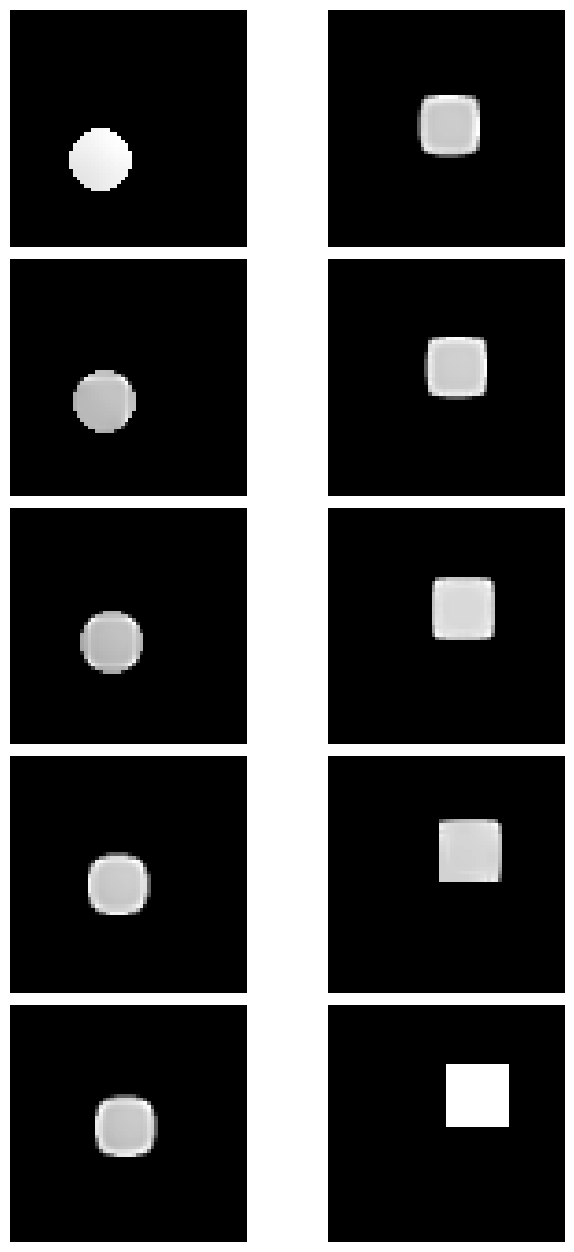

In [35]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import bisect

use_black = False

# Suppose you have 8 .png files
interps = [round(interp, 2) for interp in np.linspace(0.0, 1.0, 10)]
image_paths_initial = [
    f"images/interp/white_composite_img_p_entropic_epsilon_5.0_interp_{a}.png" for a in interps
]   
planned_indices = [2 * (i % 5) + int(i / 5) for i in range(10)]
image_paths = [image_paths_initial[planned_indices.index(j)] for j in range(10)]

# Load all images
images = [mpimg.imread(img_path) for img_path in image_paths]
# images = [img[..., :3] if img.shape[-1] == 4 else img for img in images]

fig, axes = plt.subplots(5, 2, figsize=(8, 16))  # 4 rows, 2 columns

axes = axes.flatten()

for idx, ax in enumerate(axes):
    ax.imshow(images[idx], cmap = 'gray')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)  # remove the frame
    ax.axis('off')          # double ensure it's clean

plt.subplots_adjust(wspace=0.05, hspace=0.05)  # no gaps between images
# plt.tight_layout(pad=0.05)  # no padding

plt.savefig(
    "images/interp/composite_entropic.png",
    bbox_inches='tight', pad_inches=0, dpi = 300)
plt.show()

In [30]:
image_paths

['images/interp/white_composite_img_p_epsilon_0.1_interp_0.0.png',
 'images/interp/white_composite_img_p_epsilon_0.1_interp_0.56.png',
 'images/interp/white_composite_img_p_epsilon_0.1_interp_0.11.png',
 'images/interp/white_composite_img_p_epsilon_0.1_interp_0.67.png',
 'images/interp/white_composite_img_p_epsilon_0.1_interp_0.22.png',
 'images/interp/white_composite_img_p_epsilon_0.1_interp_0.78.png',
 'images/interp/white_composite_img_p_epsilon_0.1_interp_0.33.png',
 'images/interp/white_composite_img_p_epsilon_0.1_interp_0.89.png',
 'images/interp/white_composite_img_p_epsilon_0.1_interp_0.44.png',
 'images/interp/white_composite_img_p_epsilon_0.1_interp_1.0.png']

In [28]:
planned_indices = [2 * (i % 5) + int(i / 5) for i in range(10)]
[planned_indices.index(j) for j in range(10)]

[0, 5, 1, 6, 2, 7, 3, 8, 4, 9]

In [27]:
planned_indices


[0, 2, 4, 6, 8, 1, 3, 5, 7, 9]